# IMU Fusion Algorithms
Comparing Fusion Algorithms

In [53]:
import os
import pandas as pd

In [154]:
path_to_dataset = 'datasets/'
datasets = os.listdir(path_to_dataset)
dataset = datasets[15]

data_df_file = 'datasets/'+dataset+'/combined_sensors.csv'
data_df_file

'datasets/Station_Road-2023-12-08_07-53-14/combined_sensors.csv'

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

Reading the dataset selected

In [156]:
df_imu = pd.read_csv(data_df_file,parse_dates=True)

Converting datetime to timestamp

In [157]:
df_imu['time'] = pd.to_datetime(df_imu['time'])
df_imu['time'] = df_imu['time'].astype('int64')

#### Dataset Description

In [158]:
print("Duration:",round((df_imu['time'].values[-1] - df_imu['time'].values[0])/6e+10,2)
," minutes")

Duration: 81.69  minutes


In [159]:
def invert(points):
    inverted = []
    for p in points:
        inverted.append(-p)
    return inverted

Extracting individual subsets

In [160]:
time = df_imu['time'].values
accelerometer_data = df_imu[['x_acc', 'y_acc', 'z_acc']].values
gyroscope_data = df_imu[['x_gyro', 'y_gyro', 'z_gyro']].values
magnetometer_data = df_imu[['x_mag', 'y_mag', 'z_mag']].values

## Ground Truth

In [161]:
df_gps = pd.read_csv('datasets/'+dataset+'/gps.csv')

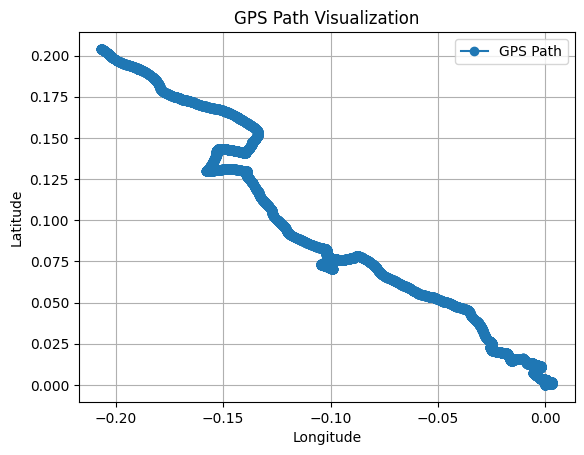

In [162]:
# Extract GPS data
time_gps = df_gps['time'].values
longitude_gps = df_gps['longitude'].values
latitude_gps = df_gps['latitude'].values

latitude_gps = latitude_gps - latitude_gps[0]
longitude_gps = longitude_gps  - longitude_gps[0]

# Plot the GPS path
plt.figure()
plt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Path Visualization')
plt.legend()
plt.grid(True)
plt.show()

## Sensor Fusion Algorithm

### Basic Method

Setting Initial Position

In [163]:
orientation_quaternion = Quaternion()

position_x = [0]
position_y = [0]
position_z = [0]

In [164]:
for i in range(1, len(time)):
    # Calculate time difference in seconds
    dt = (time[i] - time[i-1]) / 1e9  # assuming time is in nanoseconds, convert to seconds

    # Update orientation quaternion using gyroscope data
    angular_velocity = gyroscope_data[i]
    delta_quaternion = Quaternion(axis=angular_velocity, radians=np.linalg.norm(angular_velocity) * dt)
    orientation_quaternion = (orientation_quaternion * delta_quaternion).unit 

    # Get rotation matrix from the updated quaternion
    rotation_matrix = orientation_quaternion.rotation_matrix

    # Integrate accelerometer data for position estimation
    acceleration = np.array(accelerometer_data[i])
    rotated_acceleration = np.dot(rotation_matrix, acceleration)
    velocity = np.array([rotated_acceleration[0], rotated_acceleration[1], 0]) * dt  # Assuming constant velocity in x and y
    position_change = np.array(velocity) * dt  # Assuming constant velocity over the time step
    new_position = np.array([position_x[i - 1], position_y[i - 1], position_z[i - 1]]) + position_change

    # Append new position coordinates
    position_x.append(new_position[0])
    position_y.append(new_position[1])
    position_z.append(new_position[2])

Fixing Inversion

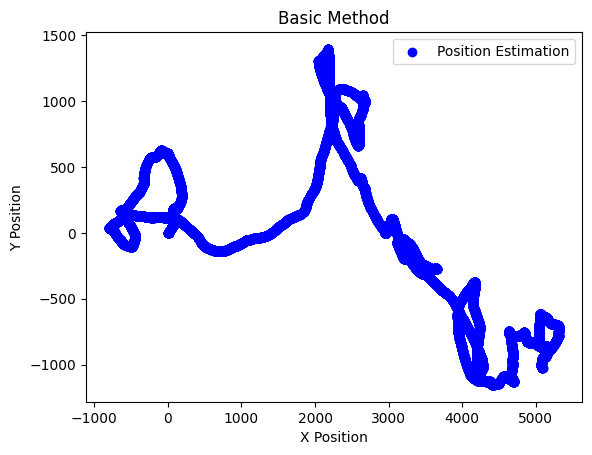

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(invert(position_x),invert(position_y), label='Position Estimation', c='b', marker='o')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
# ax.set_zlabel('Z Position')
ax.set_title('Basic Method')
ax.legend()
plt.show()

### Complementary Filter

In [166]:
# Lists to store complementary filter estimated position coordinates
comp_position_x = [0]
comp_position_y = [0]
comp_position_z = [0]

# Initialize orientation quaternion
orientation_quaternion_comp = Quaternion()

# Complementary filter parameters
alpha = 0.9  # Weight for accelerometer data
beta = 0.9   # Weight for gyroscope data

# Sensor fusion and complementary filter position estimation loop
for i in range(1, len(time)):
    dt_imu = (time[i] - time[i-1]) / 1e9

    # Update orientation quaternion using gyroscope data
    angular_velocity_imu = gyroscope_data[i]
    delta_quaternion_imu = Quaternion(axis=angular_velocity_imu, radians=np.linalg.norm(angular_velocity_imu) * dt_imu)
    orientation_quaternion_imu = (orientation_quaternion_comp * delta_quaternion_imu).unit

    # Combine accelerometer and gyroscope data using complementary filter
    acceleration_imu = np.array(accelerometer_data[i])
    rotated_acceleration_imu = np.dot(orientation_quaternion_imu.rotation_matrix, acceleration_imu)
    
    comp_position_change_imu = alpha * np.array(rotated_acceleration_imu) * dt_imu
    comp_position_change_gyro = beta * np.array(gyroscope_data[i]) * dt_imu
    
    comp_position_change = comp_position_change_imu + comp_position_change_gyro
    
    new_position_comp = np.array([comp_position_x[i - 1], comp_position_y[i - 1], comp_position_z[i - 1]]) + comp_position_change

    # Update estimated position coordinates
    comp_position_x.append(new_position_comp[0])
    comp_position_y.append(new_position_comp[1])
    comp_position_z.append(new_position_comp[2])

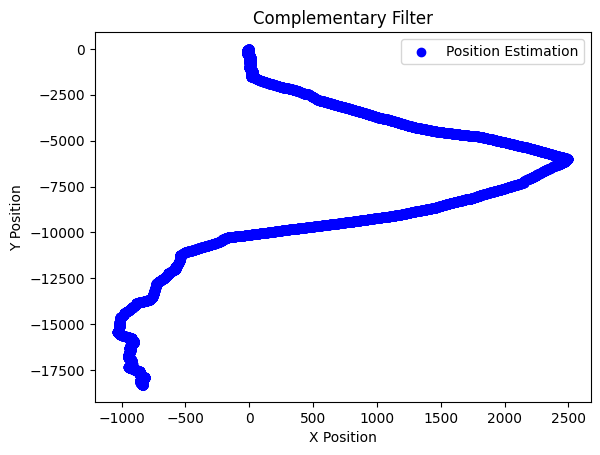

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(invert(comp_position_x), invert(comp_position_y), label='Position Estimation', c='b', marker='o')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
# ax.set_zlabel('Z Position')
ax.set_title('Complementary Filter')
ax.legend()
plt.show()

### Complementary Filter
With Magnetic Correction

In [168]:
def comp_mag(accelerometer_data,gyroscope_data,magnetometer_data,time):
    mag_corr_position_x,mag_corr_position_y,mag_corr_position_z=[0],[0],[0]
    orientation_quaternion = Quaternion()
    for i in range(1, len(time)):
        # Calculate time difference in seconds
        dt = (time[i] - time[i-1]) / 1e9  # assuming time is in nanoseconds, convert to seconds

        # Update orientation quaternion using gyroscope data
        angular_velocity = gyroscope_data[i]

        # Magnetometer data for thresholding
        magnetometer_reading = magnetometer_data[i]

        # Threshold for angular velocity based on magnetometer reading
        threshold = 0.5  # You can adjust this threshold as needed

        if np.linalg.norm(magnetometer_reading) < threshold:
            delta_quaternion = Quaternion(axis=angular_velocity, radians=np.linalg.norm(angular_velocity) * dt)
            orientation_quaternion = (orientation_quaternion * delta_quaternion).unit 

            # Get rotation matrix from the updated quaternion
            rotation_matrix = orientation_quaternion.rotation_matrix

            # Integrate accelerometer data for position estimation
            acceleration = np.array(accelerometer_data[i])
            rotated_acceleration = np.dot(rotation_matrix, acceleration)
            velocity = np.array([rotated_acceleration[0], rotated_acceleration[1], 0]) * dt  # Assuming constant velocity in x and y
            position_change = np.array(velocity) * dt  # Assuming constant velocity over the time step
            new_position = np.array([position_x[i - 1], position_y[i - 1], position_z[i - 1]]) + position_change

            
        else:
            # Use magnetometer data to correct or reduce deviation
            # You may need to customize this correction based on your specific use case
            # Here, we simply adjust the orientation quaternion based on magnetometer data
            magnetometer_correction = Quaternion(axis=magnetometer_reading, radians=np.linalg.norm(magnetometer_reading) * dt)
            orientation_quaternion = (orientation_quaternion * magnetometer_correction).unit 

            # Update position using accelerometer data (without gyroscope update)
            acceleration = np.array(accelerometer_data[i])
            velocity = np.array([acceleration[0], acceleration[1], 0]) * dt  # Assuming constant velocity in x and y
            position_change = np.array(velocity) * dt  # Assuming constant velocity over the time step
            new_position = np.array([mag_corr_position_x[i - 1], mag_corr_position_y[i - 1], mag_corr_position_z[i - 1]]) + position_change

        # Append new position coordinates
        mag_corr_position_x.append(new_position[0])
        mag_corr_position_y.append(new_position[1])
        mag_corr_position_z.append(new_position[2])
    return mag_corr_position_x,mag_corr_position_y,mag_corr_position_z

In [169]:
mag_corr_position_x,mag_corr_position_y,mag_corr_position_z = comp_mag(accelerometer_data,gyroscope_data,magnetometer_data,time)

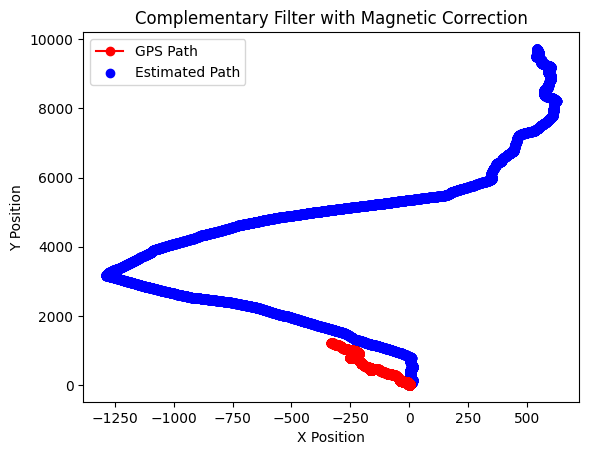

In [170]:
fig = plt.figure()
ax = fig.add_subplot(111)
scale_factor=[1600,6000]
ax.plot(longitude_gps*scale_factor[0], latitude_gps*scale_factor[1], label='GPS Path', marker='o',c='r')
ax.scatter(mag_corr_position_x,mag_corr_position_y, label='Estimated Path', c='b', marker='o')


ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Complementary Filter with Magnetic Correction')
ax.legend()
plt.show()

In [171]:
df_comp = df_imu.copy()

In [172]:
df_comp['Comp_X'] = np.array(mag_corr_position_x)
df_comp['Comp_Y'] = np.array(mag_corr_position_y)

In [173]:
df_comp

,time,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,x_mag,y_mag,z_mag,Comp_X,Comp_Y
0,1702021994466597000,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,0.000000e+00,0.000000
1,1702021994468987600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,-1.260151e-07,0.000016
2,1702021994677308700,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,-9.570449e-04,0.118016
3,1702021995426736600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,-1.334126e-02,1.645149
4,1702021995427619000,0.38700,2.85105,8.805000,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,-1.334095e-02,1.645151
...,...,...,...,...,...,...,...,...,...,...,...,...
15377,1702026894775270000,1.40205,-0.87405,8.473050,-0.298788,-0.086213,0.294113,-193.912506,-105.300003,359.418762,5.430964e+02,9723.222329
15378,1702026894983986700,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-193.912506,-105.300003,359.418762,5.431575e+02,9723.184253
15379,1702026895234652000,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,5.432456e+02,9723.129334
15380,1702026895729403600,-0.32100,-0.98400,9.564000,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,5.431670e+02,9722.888471


### Complementary Filter
with Machine learning Correction

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from pyquaternion import Quaternion

#### Converting Positions to delta changes

In [175]:
def calculateDeltas(df,col,prefix='x'):
    dx = df[col].values
    
    df[prefix+'_pre_position'] = np.insert(dx[:-1],0,0,axis=0)
    df[prefix+'_change'] = df[col] - df[prefix+'_pre_position']

    return df

In [176]:
# c_x = df_comp['Comp_X'].values
# c_y = df_comp['Comp_Y'].values

In [177]:
# c_x = np.insert(c_x[:-1],0,0,axis=0)
# c_y = np.insert(c_y[:-1],0,0,axis=0)

In [178]:
# df_comp['x_pre_position'] = c_x
# df_comp['y_pre_position'] = c_y

In [179]:
# df_comp['x_change'] = df_comp['Comp_X'] - df_comp['x_pre_position']
# df_comp['y_change'] = df_comp['Comp_Y'] - df_comp['y_pre_position']

In [180]:
df_comp = calculateDeltas(df_comp.copy(),'Comp_X','x')
df_comp = calculateDeltas(df_comp.copy(),'Comp_Y','y')

In [181]:
df_comp

,time,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,x_mag,y_mag,z_mag,Comp_X,Comp_Y,x_pre_position,x_change,y_pre_position,y_change
0,1702021994466597000,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
1,1702021994468987600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,-1.260151e-07,0.000016,0.000000e+00,-1.260151e-07,0.000000,0.000016
2,1702021994677308700,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,-9.570449e-04,0.118016,-1.260151e-07,-9.569189e-04,0.000016,0.118000
3,1702021995426736600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,-1.334126e-02,1.645149,-9.570449e-04,-1.238421e-02,0.118016,1.527133
4,1702021995427619000,0.38700,2.85105,8.805000,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,-1.334095e-02,1.645151,-1.334126e-02,3.013297e-07,1.645149,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15377,1702026894775270000,1.40205,-0.87405,8.473050,-0.298788,-0.086213,0.294113,-193.912506,-105.300003,359.418762,5.430964e+02,9723.222329,5.427450e+02,3.513875e-01,9723.441387,-0.219058
15378,1702026894983986700,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-193.912506,-105.300003,359.418762,5.431575e+02,9723.184253,5.430964e+02,6.107703e-02,9723.222329,-0.038076
15379,1702026895234652000,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,5.432456e+02,9723.129334,5.431575e+02,8.809514e-02,9723.184253,-0.054919
15380,1702026895729403600,-0.32100,-0.98400,9.564000,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,5.431670e+02,9722.888471,5.432456e+02,-7.857411e-02,9723.129334,-0.240863


In [182]:
# gps_x = df_gps['longitude'].values
# gps_y = df_gps['latitude'].values

In [183]:
# gps_x = np.insert(gps_x[:-1],0,0,axis=0)
# gps_y = np.insert(gps_y[:-1],0,0,axis=0)

In [184]:
# df_gps['x_pre_position'] = gps_x
# df_gps['y_pre_position'] = gps_y

In [185]:
# df_gps['x_change'] = df_gps['longitude'] - df_gps['x_pre_position']
# df_gps['y_change'] = df_gps['latitude'] - df_gps['y_pre_position']

In [186]:
df_gps

,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,2023-12-08 07:53:14.466597000,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720
1,2023-12-08 07:53:14.468987600,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720
2,2023-12-08 07:53:14.677308700,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720
3,2023-12-08 07:53:15.426736600,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720
4,2023-12-08 07:53:15.427619000,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720
...,...,...,...,...,...,...,...,...,...,...,...
15377,2023-12-08 09:14:54.775270000,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707
15378,2023-12-08 09:14:54.983986700,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707
15379,2023-12-08 09:14:55.234652000,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707
15380,2023-12-08 09:14:55.729403600,4901.142,0.000000,1.4,5.910061,3.900,0.073879,0.000000,100.200005,-1.178793,51.661717


In [187]:
df_gps = calculateDeltas(df_gps.copy(),'longitude','x')
df_gps = calculateDeltas(df_gps.copy(),'latitude','y')

In [188]:
df_gps

,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude,x_pre_position,x_change,y_pre_position,y_change
0,2023-12-08 07:53:14.466597000,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720,0.000000,-0.972102,0.000000,51.457720
1,2023-12-08 07:53:14.468987600,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720,-0.972102,0.000000,51.457720,0.000000
2,2023-12-08 07:53:14.677308700,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720,-0.972102,0.000000,51.457720,0.000000
3,2023-12-08 07:53:15.426736600,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720,-0.972102,0.000000,51.457720,0.000000
4,2023-12-08 07:53:15.427619000,0.220,0.000000,0.0,2.737573,16.486,0.000000,0.000000,95.500000,-0.972102,51.457720,-0.972102,0.000000,51.457720,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15377,2023-12-08 09:14:54.775270000,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707,-1.178768,-0.000016,51.661695,0.000012
15378,2023-12-08 09:14:54.983986700,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707,-1.178784,0.000000,51.661707,0.000000
15379,2023-12-08 09:14:55.234652000,4900.142,28.200001,1.4,5.900061,3.900,1.661009,320.631042,100.200005,-1.178784,51.661707,-1.178784,0.000000,51.661707,0.000000
15380,2023-12-08 09:14:55.729403600,4901.142,0.000000,1.4,5.910061,3.900,0.073879,0.000000,100.200005,-1.178793,51.661717,-1.178784,-0.000008,51.661707,0.000010


In [189]:
cols_X = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro', 'x_mag', 'y_mag', 'z_mag', 'x_change', 'y_change']
cols_Y = ['x_change','y_change']

In [190]:
motion_data = df_comp[cols_X].values
gps_coordinates = df_gps[cols_Y].values
# Standardize the data
scaler_motion = StandardScaler()
scaler_gps = StandardScaler()

motion_data_scaled = scaler_motion.fit_transform(motion_data)
gps_coordinates_scaled = scaler_gps.fit_transform(gps_coordinates)

In [191]:
# Prepare training data as sequences
sequence_length = 5  # You can adjust this parameter based on the characteristics of your data
X, y = [], []

In [192]:
for i in range(len(motion_data_scaled) - sequence_length):
    X.append(motion_data_scaled[i:i+sequence_length])
    y.append(gps_coordinates_scaled[i+sequence_length])

X = np.array(X)
y = np.array(y)

In [193]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(gps_coordinates_scaled.shape[1]))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='mse')


In [197]:
# Train the model
history = model.fit(X_train, y_train, epochs=90, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict GPS coordinates
predicted_gps_coordinates_scaled = model.predict(X)

Epoch 1/90


385/385 [==============================] - 10s 12ms/step - loss: 1.2549e-04 - val_loss: 3.2485e-05
Epoch 2/90
385/385 [==============================] - 4s 11ms/step - loss: 3.0297e-05 - val_loss: 3.1048e-05
Epoch 3/90
385/385 [==============================] - 4s 11ms/step - loss: 2.6055e-05 - val_loss: 2.3809e-05
Epoch 4/90
385/385 [==============================] - 4s 11ms/step - loss: 2.4498e-05 - val_loss: 3.0071e-05
Epoch 5/90
385/385 [==============================] - 4s 11ms/step - loss: 2.2170e-05 - val_loss: 2.0816e-05
Epoch 6/90
385/385 [==============================] - 4s 11ms/step - loss: 2.1549e-05 - val_loss: 1.9176e-05
Epoch 7/90
385/385 [==============================] - 4s 11ms/step - loss: 2.0172e-05 - val_loss: 2.0219e-05
Epoch 8/90
385/385 [==============================] - 6s 15ms/step - loss: 2.0175e-05 - val_loss: 2.0985e-05
Epoch 9/90
385/385 [==============================] - 10s 25ms/step - loss: 1.9963e-05 - val_loss: 1.8022e-05
Epoch 10/90
385/385 [=======

In [198]:
# Inverse transform to get original scale
predicted_gps_coordinates = scaler_gps.inverse_transform(predicted_gps_coordinates_scaled)

# Evaluate the model
mse = mean_squared_error(gps_coordinates[sequence_length:], predicted_gps_coordinates)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.738885353282666e-09


In [199]:
import pickle

In [200]:
with open('models/comp_linear_reg.mod','wb') as m:
    pickle.dump(model,m)

### ML Model Test

In [201]:
import pickle
model_load = False
with open('models/comp_linear_reg.mod','rb') as m:
    model_load = pickle.load(m)

In [239]:
dataset = datasets[4]

data_df_file = 'datasets/'+dataset+'/combined_sensors.csv'
data_df_file

'datasets/2023-06-02_12-14-13/combined_sensors.csv'

In [240]:
df_imu_test = pd.read_csv(data_df_file,parse_dates=True)

In [241]:
df_imu_test['time'].values[-1]

'2023-06-02 13:16:55.731911700'

In [242]:
df_imu_test['time'] = pd.to_datetime(df_imu_test['time'])
df_imu_test['time'] = df_imu_test['time'].astype('int64')
print("Duration:",round((df_imu_test['time'].values[-1] - df_imu_test['time'].values[0])/6e+10,2)
," minutes")

Duration: 62.7  minutes


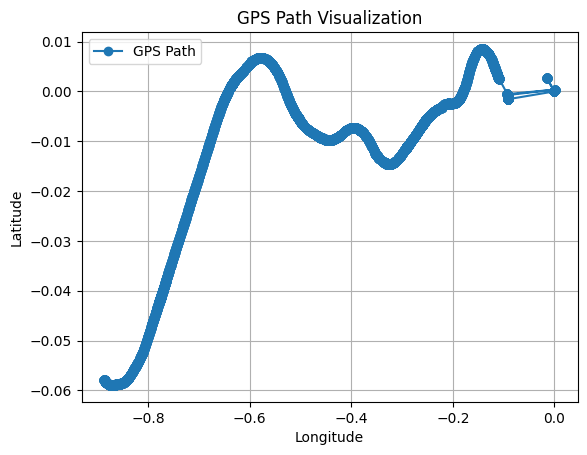

In [243]:
df_gps = pd.read_csv('datasets/'+dataset+'/gps.csv')
# Extract GPS data
time_gps = df_gps['time'].values
longitude_gps = df_gps['longitude'].values
latitude_gps = df_gps['latitude'].values

latitude_gps = latitude_gps - latitude_gps[0]
longitude_gps = longitude_gps  - longitude_gps[0]

# Plot the GPS path
plt.figure()
plt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Path Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [244]:
df_imu_test['time'] = pd.to_datetime(df_imu_test['time'])
df_imu_test['time'] = df_imu_test['time'].astype('int64')

In [245]:
time_test = df_imu_test['time'].values
accelerometer_data_test = df_imu_test[['x_acc', 'y_acc', 'z_acc']].values
gyroscope_data_test = df_imu_test[['x_gyro', 'y_gyro', 'z_gyro']].values
magnetometer_data_test = df_imu_test[['x_mag', 'y_mag', 'z_mag']].values

In [246]:
mag_corr_position_x,mag_corr_position_y,mag_corr_position_z = comp_mag(
    accelerometer_data_test,
    gyroscope_data_test,
    magnetometer_data_test,
    time_test)

In [247]:
df_comp_test = df_imu_test.copy()

df_comp_test['Comp_X'] = np.array(mag_corr_position_x)
df_comp_test['Comp_Y'] = np.array(mag_corr_position_y)

df_comp_test = calculateDeltas(df_comp_test.copy(),'Comp_X','x')
df_comp_test = calculateDeltas(df_comp_test.copy(),'Comp_Y','y')

In [248]:
motion_data_test = df_comp_test[cols_X].values
# Prepare training data as sequences
sequence_length = 5  # You can adjust this parameter based on the characteristics of your data
X, y = [], []

scaler_motion = StandardScaler()
motion_data_scaled = scaler_motion.fit_transform(motion_data_test)

for i in range(len(motion_data_scaled) - sequence_length):
    X.append(motion_data_scaled[i:i+sequence_length])
    y.append(gps_coordinates_scaled[i+sequence_length])

X = np.array(X)
y = np.array(y)

In [249]:
predictions = model_load.predict(X)

365/365 [==============================] - 1s 4ms/step


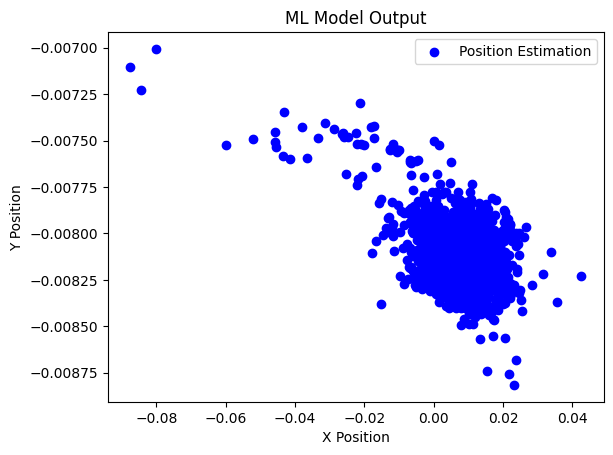

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(list(zip(*predictions))[0]), list(list(zip(*predictions))[1]), label='Position Estimation', c='b', marker='o')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
# ax.set_zlabel('Z Position')
ax.set_title('ML Model Output')
ax.legend()
plt.show()